In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d deathtrooper/eyepacs-airogs-light

 98% 297M/302M [00:02<00:00, 187MB/s]
100% 302M/302M [00:02<00:00, 151MB/s]


In [3]:
!unzip /content/eyepacs-airogs-light.zip

Streaming output truncated to the last 5000 lines.
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1485.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1486.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1487.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1488.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1489.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-149.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1490.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1491.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1492.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1493.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1494.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1495.jpg  
  inflating: release-raw/release-raw/train/NRG/EyePACS-NRG-1496.jpg  
  inflating: release-raw/release-raw/tra

In [4]:
import tensorflow as tf

In [5]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import keras
import numpy as np
import random
import shutil

In [6]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
target = 256

# inject noise but keep dark parts black
def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    randStd = random.uniform(0, 10.0) # 15
    gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    image[mask == 0] = [0,0,0]
    image = preprocess_input(image)
    return image

dataPath = '/content/release-crop/release-crop'

# combine two unique generators using noise injection
batchSize = 4
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.95, 1.05))
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + '/train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + '/train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + '/validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + '/test', color_mode='rgb')

Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
from keras.layers import GlobalMaxPool2D
# import tf.keras.layers.GlobalMaxPooling2D

# simple model that uses mobilenet background
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    transfer = keras.applications.MobileNetV3Large(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    x = transfer.get_layer(index=142).output

    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.15)(x)

    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

12683000/12683000 [==============================] - 0s 0us/step


In [8]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=25, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/25
2500/2500 [==============================] - ETA: 0s - loss: 41.6601 - accuracy: 0.5737

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2500/2500 [==============================] - 180s 64ms/step - loss: 41.6601 - accuracy: 0.5737 - val_loss: 26.3328 - val_accuracy: 0.7537 - lr: 1.0000e-04
Epoch 2/25
2500/2500 [==============================] - 162s 65ms/step - loss: 19.2607 - accuracy: 0.6808 - val_loss: 11.4409 - val_accuracy: 0.8019 - lr: 1.0000e-04
Epoch 3/25
2500/2500 [==============================] - 162s 65ms/step - loss: 7.3258 - accuracy: 0.7475 - val_loss: 3.5178 - val_accuracy: 0.8407 - lr: 1.0000e-04
Epoch 4/25
2500/2500 [==============================] - 161s 64ms/step - loss: 1.9732 - accuracy: 0.8081 - val_loss: 0.8552 - val_accuracy: 0.8778 - lr: 1.0000e-04
Epoch 5/25
2500/2500 [==============================] - 161s 65ms/step - loss: 0.6244 - accuracy: 0.8586 - val_loss: 0.4035 - val_accuracy: 0.8944 - lr: 1.0000e-04
Epoch 6/25
2500/2500 [==============================] - 157s 63ms/step - loss: 0.3791 - accuracy: 0.8921 - val_loss: 0.3204 - val_accuracy: 0.8963 - lr: 1.0000e-04
Epoch 7/25
2500/2500 [=

In [9]:
import numpy as np
import pandas as pd
history_df = pd.DataFrame(history.history)

In [10]:
history_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,41.660149,0.5737,26.332777,0.753704,0.0001
1,19.260675,0.6808,11.440924,0.801852,0.0001
2,7.325805,0.7475,3.517759,0.840741,0.0001
3,1.973228,0.8081,0.855172,0.877778,0.0001
4,0.624394,0.8586,0.403548,0.894444,0.0001


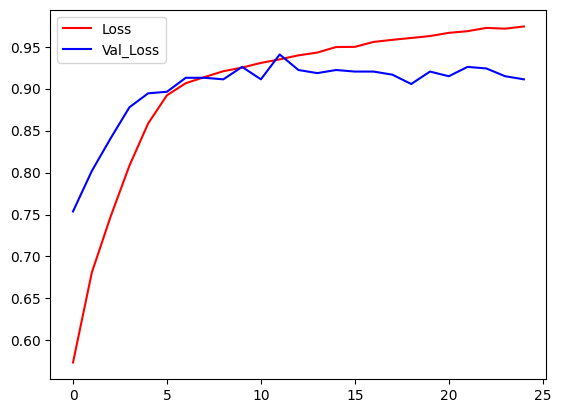

In [13]:
plt.plot(history_df['accuracy'],label = 'Loss',color = 'red')
plt.plot(history_df['val_accuracy'],label = "Val_Loss",color = "blue")
plt.legend()
plt.show()

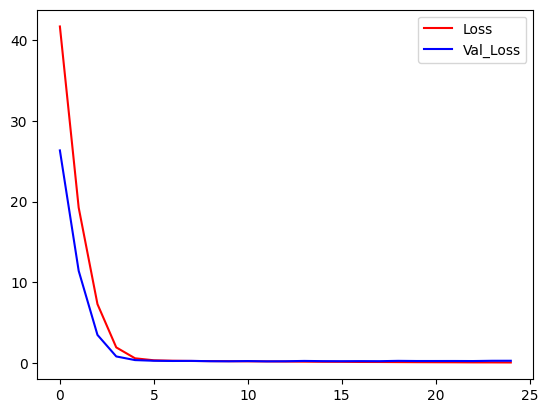

In [12]:
plt.plot(history_df['loss'],label = 'Loss',color = 'red')
plt.plot(history_df['val_loss'],label = "Val_Loss",color = "blue")
plt.legend()
plt.show()